# Reconhecimento de Numerais Escritos a Mão

Utilizaremos a biblioteca MNIST.<br>
As instruções para instalação do python-mnist podem ser encontradas em:<br>
https://pypi.org/project/python-mnist/

In [1]:
import numpy as np
import cv2
from mnist import MNIST
import matplotlib.pyplot as plt
import timeit

O banco de dados MNIST possui 60000 amostras de treinamento e 10000 amostras de teste.<br>
Abaixo, os dados são normalizados para o intervalo $[0,1]$.<br>
Também vamos garantir que os dados são do tipo numpy array.

In [2]:
mndata = MNIST('/home/thelmo/local/python-mnist/data')
Xtrain, ytrain = mndata.load_training()
Xtrain = np.array(Xtrain) / 255.0
ytrain = np.array(ytrain)
Xtest, ytest = mndata.load_testing()
Xtest = np.array(Xtest) / 255.0
ytest = np.array(ytest)

Vejamos alguns exemplos das amostras do MNIST:

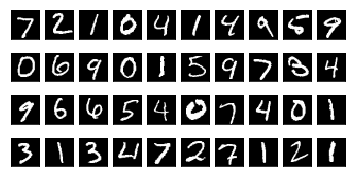

In [3]:
fig = plt.figure(figsize=(6, 3))  # width, height in inches

for i in range(40):
    sub = fig.add_subplot(4, 10, i + 1)
    sub.imshow(np.reshape(Xtest[i,:], (28,28)), cmap='gray')
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_xticklabels([])
    sub.set_yticklabels([])

Agora, vamos calcular a matriz de covariância dos dados de <b>treinamento</b> $A$<br>
e sua decomposição espectral, isto é, $A = Q \Lambda Q^T$.

In [4]:
M = np.mean(Xtrain, axis=0) # média de cada coluna
Z = Xtrain - M # centralização dos dados
A = np.dot(Z.transpose(),Z) # cálculo da matriz de covariância

# Calcula a decompisção espectral de A
# _w é o vetor com os autovalores de A
# _Q é a matriz ortogonal com os autovetores de A
_w, _Q = np.linalg.eigh(A)

# Ordena os autovalores de maior para o menor
sort_indices = np.argsort(_w)[::-1]
w = _w[sort_indices]
Q = _Q[:,sort_indices]

Vejamos as 20 primeiras "autoimagens":

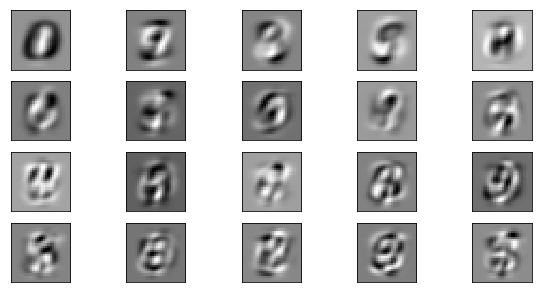

In [5]:
fig = plt.figure(figsize=(10, 5))  # width, height in inches

for i in range(20):
    sub = fig.add_subplot(4, 5, i + 1)
    sub.imshow(np.reshape(Q[:,i], (28,28)), cmap='gray')
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_xticklabels([])
    sub.set_yticklabels([])

Vejamos agora como a variabilidade acumulada varia com o número de autovalores utilizados.

Text(0,0.5,'Variabilidade Acumulada')

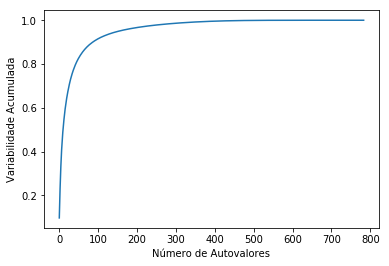

In [6]:
total_var = np.sum(w)
y_plot = np.cumsum(w) / total_var
x_plot = np.array(range(len(w)))

plt.plot(x_plot, y_plot)
plt.xlabel('Número de Autovalores')
plt.ylabel('Variabilidade Acumulada')

Calculemos a matriz $\hat{P}$ com as $r$ coordenadas em relação à base de autovetores.

In [7]:
def reduced_coordinates(r):
    # Calcula as componentes principais:
    return np.dot(Xtrain, Q[:,0:r]), np.dot(Xtest, Q[:,0:r])

Finalmente, vamos classificar as imagens de teste e calcular a acurácia.<br>
Utilizaremos a distância euclidiana.<br>
Não faremos a busca completa, pois levaríamos aproximadamente 2 horas.

In [8]:
r = 40
Ytrain, Ytest = reduced_coordinates(r)
ntrains = 6000
ntests = 10000
count = 0
start_time = timeit.default_timer()
for i in range(ntests):
    dist = []
    for j in range(ntrains):
        dist = np.append(dist, np.linalg.norm(Ytest[i,:] - Ytrain[j,:]))
    index = np.argmin(dist)
    if ytrain[index] == ytest[i]:
        count += 1
    if not(i%1000):
        print('-->', i, end=" ")
elapsed = timeit.default_timer() - start_time
acc = count / ntests

print('\nVariabilidade acumulada até o {}-ésimo autovalor: {:4.1f} %.'.format(r,y_plot[r]*100))
print('Acurácia = {:5.2f} %.'.format(acc*100))
print('Tempo de execução: {:6.2f} s.'.format(elapsed))

--> 0 --> 1000 --> 2000 --> 3000 --> 4000 --> 5000 --> 6000 --> 7000 --> 8000 --> 9000 
Variabilidade acumulada até o 40-ésimo autovalor: 79.1 %.
Acurácia = 94.32 %.
Tempo de execução: 597.74 s.


Lembremos que os resultados acima <b>não</b> foram obtidos com uma busca completa.

## Alguns Resultados

ntests = 10000 e ntrains = 6000:<br>
Com $n$ = 10 (variabilidade acumulada = 50.9%), obteve:<br>
acurácia = 87.92% em 608.26 segundos.

Com $n$ = 20 (variabilidade acumulada = 65.4%), obteve:<br>
acurácia = 93.5% em 613.12 segundos.

Com $n$ = 30 (variabilidade acumulada = 73.7%), obteve:<br>
acurácia = 94.6% em 615.89 segundos.

Com $n$ = 40 (variabilidade acumulada = 79.1%), obteve:<br>
acurácia = 94.32% em 616.68 segundos.

Com $n$ = 50 (variabilidade acumulada = 82.8%), obteve:<br>
acurácia = 94.4 % em 610.55 segundos.

Com $n$ = 100 (variabilidade acumulada = 91.6%), obteve:<br>
acurácia = 94.1 % em 618.02 segundos.

Com $n$ = 150 (variabilidade acumulada = 94.9%), obteve:<br>
acurácia = 93.8 % em 622.47 segundos.

Com $n$ = 200 (variabilidade acumulada = 96.7%), obteve:<br>
acurácia = 93.8 % em 638.07 segundos.

____________________________________________________________
ntests = 1000 e ntrains = 60000:<br>
Com $n$ = 50 (variabilidade acumulada = 82.8%), obteve:<br>
acurácia = 96.7 % em 947.40 segundos.

## Acurácia versus Variabilidade Acumulada

Vejamos se podemos acelerar o processo e mostrar num gráfico<br>
a relação entre a variabilidade acumulada e a acurácia.<br>
Iniciemos, calculando os centroides das classes.

In [9]:
# Calcula os centroides das amostras de treinamento para cada classe
def class_centroids(r):
    centroids = np.zeros((10,r))
    count = np.zeros(10)
    Ytrain, _ = reduced_coordinates(r)
    for k in range(10):
        centroids[k] = np.sum(Ytrain[ytrain==k,:], axis=0)
        count[k] = np.sum(ytrain==k)
    return (centroids.transpose() / count).transpose() # as transposta foram usadas para permitir broadcast

In [10]:
ntests = 10000
r = 400
Ytrain, Ytest = reduced_coordinates(r)
centroids = class_centroids(r)
count = 0
for i in range(ntests):
    dist = []
    for k in range(10):
        dist = np.append(dist, np.linalg.norm(Ytest[i,:] - centroids[k,:]))
    index = np.argmin(dist)
    if ytest[i] == index:
        count += 1
acc = count / ntests

print('Variabilidade até o {}-ésimo autovalor: {:4.1f} %.'.format(r,y_plot[r]*100))
print('Acurácia = {:5.2f} %.'.format(acc*100))

Variabilidade até o 400-ésimo autovalor: 99.6 %.
Acurácia = 82.03 %.


Agora vamos plotar um gráfico de acurácia por números de autovetores usados.

Text(0,0.5,'Acurácia')

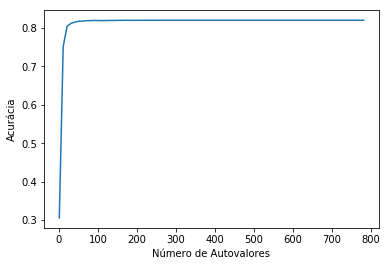

In [11]:
ntests = 10000
acc = []
for r in range(1,784,10):
    Ytrain, Ytest = reduced_coordinates(r)
    centroids = class_centroids(r)
    count = 0
    for i in range(ntests):
        dist = []
        for k in range(10):
            dist = np.append(dist, np.linalg.norm(Ytest[i,:] - centroids[k,:]))
        index = np.argmin(dist)
        if ytest[i] == index:
            count += 1
    acc = np.append(acc, count / ntests)

x_plot = list(range(1,784,10))
plt.plot(x_plot, acc)
plt.xlabel('Número de Autovalores')
plt.ylabel('Acurácia')

Apesar da acurácia usando os centroides ser inferior à acurácia usando os vetores de treinamento,<br>
podemos ver que basta utilizar de 50 a 100 autovetores principais para obter a acurácia "máxima"<br>
do método de classificação utilizado (nesse cao, K-NN, com k = 1).